# 1. Linear Regression
Examining the relationship between a player's pass volume and completion percentage

In [4]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from adjustText import adjust_text

Load data from StatsBomb GitHub page.

In [5]:
base_url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
comp_url = base_url + "matches/{}/{}.json"
match_url = base_url + "events/{}.json"

We will use a modification of the `parse_data` function were we extract `passes` and only the attributes `player_id` and `outcome`.

In [6]:
def parse_data(competition_id, season_id):
    matches = requests.get(url=comp_url.format(competition_id, season_id)).json()
    match_ids = [match['match_id'] for match in matches]

    all_events = []
    for match_id in match_ids:

        events = requests.get(url=match_url.format(match_id)).json()
        
        passes = [x for x in events if x['type']['name'] == "Pass"]
        for p in passes:
            attributes = {
                "player_id": p['player']['id'],
                "outcome": 0 if 'outcome' in p['pass'].keys() else 1,
                "length": p["pass"]["length"],
            }
            all_events.append(attributes)
            
    return pd.DataFrame(all_events)

In [7]:
WC_id = 43
season_id = 3
df = parse_data(WC_id, season_id)

We will now caculate the total number of passes and pass completion percentage for each player (player_id).

In [8]:
avg_len = df.groupby("player_id")["length"].mean()
total_passes = df.groupby("player_id")["outcome"].sum()
percentage = df.groupby("player_id")["outcome"].mean()

The total passes and pass percentage for every player can now be plotted in a scatter to give an initial thought about the correlation.

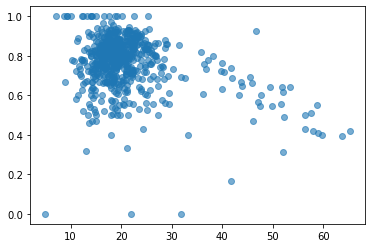

In [9]:
plt.scatter(avg_len, percentage, alpha = 0.6)
plt.show()

We will use LinearRegression from `sklearn` to peform the linear regression on the total passes and pass completion%.

In [10]:
from sklearn.linear_model import LinearRegression

Below we build a Linear Regression model, where we try to predict `percentage` with the features of the `total_passes`.

In [11]:
model = LinearRegression()
fit = model.fit([[x] for x in avg_len], percentage)
print("Coefficients: {}".format(fit.coef_))
print("Intercept: {}".format(fit.intercept_))

Coefficients: [-0.00539982]
Intercept: 0.8761729601723585


In [21]:
xfit = [0,60]
yfit = model.predict([[x] for x in xfit])

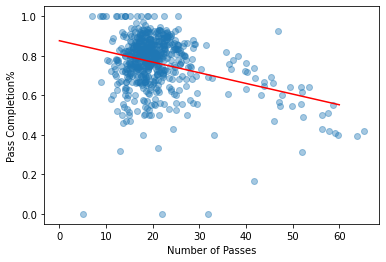

In [22]:
plt.scatter(avg_len, percentage, alpha=0.4)
plt.plot(xfit, yfit, color="r")
plt.xlabel("Number of Passes")
plt.ylabel("Pass Completion%")
plt.show()

#### In this section I will explore the dataset myself and perform LinearRegression on other interesting metrics.

In [11]:
def parse_data1(competition_id, season_id):
    matches = requests.get(url=comp_url.format(competition_id, season_id)).json()
    match_ids = [match["match_id"] for match in matches]
    
    
    all_events = []
    for match_id in match_ids:
        
        events = requests.get(url=match_url.format(match_id)).json()
        
        carries_passes = [x for x in events if x["type"]["name"] == "Carry" or x["type"]["name"] == "Pass"]
        
        for x in carries_passes:
            if x["type"]["name"] == "Pass":
                attributes = {
                    "player_name": x["player"]["name"],
                    "length": x["pass"]["length"],
                }
            elif x["type"]["name"] == "Carry":
                attributes = {
                    "player_name": x["player"]["name"],
                    "duration": x["duration"],
                } 
            all_events.append(attributes)
        
    
    
    return pd.DataFrame(all_events)

In [12]:
WC_data = parse_data1(WC_id, season_id)

In [13]:
WC_data

,player_name,length,duration
0,Christian Dannemann Eriksen,24.331050,NaN
1,Mathias Jattah-Njie Jørgensen,NaN,1.400
2,Mathias Jattah-Njie Jørgensen,60.876926,NaN
3,Domagoj Vida,25.632011,NaN
4,Thomas Delaney,5.000000,NaN
...,...,...,...
113397,Albin Ekdal,43.931767,NaN
113398,Ludwig Augustinsson,17.804493,NaN
113399,Sebastian Larsson,NaN,0.867
113400,İlkay Gündoğan,NaN,1.973


In [14]:
carry_duration = WC_data.groupby("player_name")["duration"].sum()
pass_length = WC_data.groupby("player_name")["length"].sum()

In [15]:
pass_length

player_name
Aaron Mooy                        4119.687152
Abdalla Mahmoud El Said Bekhit    2683.655368
Abdiel Arroyo Molinar              115.952544
Abdullah Ibrahim Al Maiouf        1973.003456
Abdullah Ibrahim Otayf            4571.793110
                                     ...     
İlkay Gündoğan                     966.877033
Łukasz Fabiański                  1006.694207
Łukasz Piszczek                   2221.989955
Łukasz Teodorczyk                   93.872764
Šime Vrsaljko                     7318.293481
Name: length, Length: 602, dtype: float64

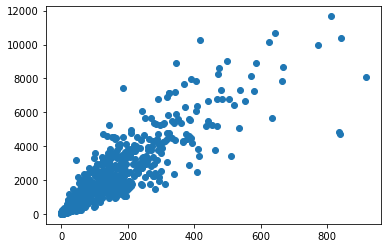

In [16]:
plt.scatter(carry_duration, pass_length)
plt.show()

In [17]:
model1 = LinearRegression()
fit1 = model.fit([[x] for x in carry_duration], pass_length)
print(fit1.coef_)
print(fit1.intercept_)

[12.34252569]
335.7392054760055


In [18]:
xfit1 = [0, 1000]
yfit1 = model.predict([[x] for x in xfit1])

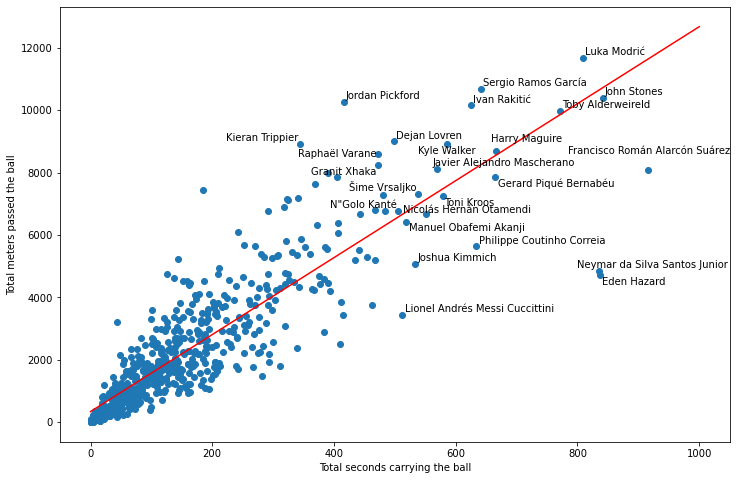

In [19]:
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(carry_duration, pass_length)
plt.plot(xfit1, yfit1, "r")
plt.xlabel("Total seconds carrying the ball")
plt.ylabel("Total meters passed the ball")

labels = [ax.annotate(txt, (carry_duration[i], pass_length[i])) 
          for i, txt in enumerate(carry_duration.index) 
          if pass_length.iloc[i] > 8000 or carry_duration.iloc[i] > 500]
adjust_text(labels)
#for i, txt in enumerate(carry_duration.index):
#    if pass_length.iloc[i] > 7000 or carry_duration.iloc[i] > 500:
#        ax.annotate(txt, (carry_duration[i], pass_length[i]))
plt.show()

------------------------------------------------------------------------

-----------------------------------

### Here is the workflow for creating a Linear Regression Model

In [20]:
def parse_data1(competition_id, season_id):
    matches = requests.get(url=comp_url.format(competition_id, season_id)).json()
    match_ids = [match["match_id"] for match in matches]
    
    
    all_events = []
    for match_id in match_ids:
        
        events = requests.get(url=match_url.format(match_id)).json()
        
        carries_passes = [x for x in events if x["type"]["name"] == "Carry" or x["type"]["name"] == "Pass"]
        
        for x in carries_passes:
            if x["type"]["name"] == "Pass":
                attributes = {
                    "player_name": x["player"]["name"],
                    "length": x["pass"]["length"],
                }
            elif x["type"]["name"] == "Carry":
                attributes = {
                    "player_name": x["player"]["name"],
                    "duration": x["duration"],
                } 
            all_events.append(attributes)
        
    
    
    return pd.DataFrame(all_events)

In [21]:
CL_id = 43
CL_season = 3

In [22]:
CL_05_data = parse_data1(CL_id, CL_season)

In [23]:
CL_05_data

,player_name,length,duration
0,Christian Dannemann Eriksen,24.331050,NaN
1,Mathias Jattah-Njie Jørgensen,NaN,1.400
2,Mathias Jattah-Njie Jørgensen,60.876926,NaN
3,Domagoj Vida,25.632011,NaN
4,Thomas Delaney,5.000000,NaN
...,...,...,...
113397,Albin Ekdal,43.931767,NaN
113398,Ludwig Augustinsson,17.804493,NaN
113399,Sebastian Larsson,NaN,0.867
113400,İlkay Gündoğan,NaN,1.973


In [24]:
CL_carry = CL_05_data.groupby("player_name")["duration"].sum()
CL_pass = CL_05_data.groupby("player_name")["length"].sum()

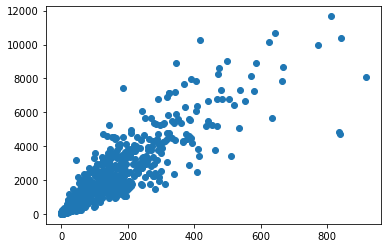

In [25]:
plt.scatter(CL_carry, CL_pass)
plt.show()

In [26]:
model1 = LinearRegression()
fit1 = model.fit([[x] for x in CL_carry], CL_pass)
print(fit1.coef_)
print(fit1.intercept_)

[12.34252569]
335.7392054760055


In [27]:
xfit1 = [0, 1000]
yfit1 = model.predict([[x] for x in xfit1])

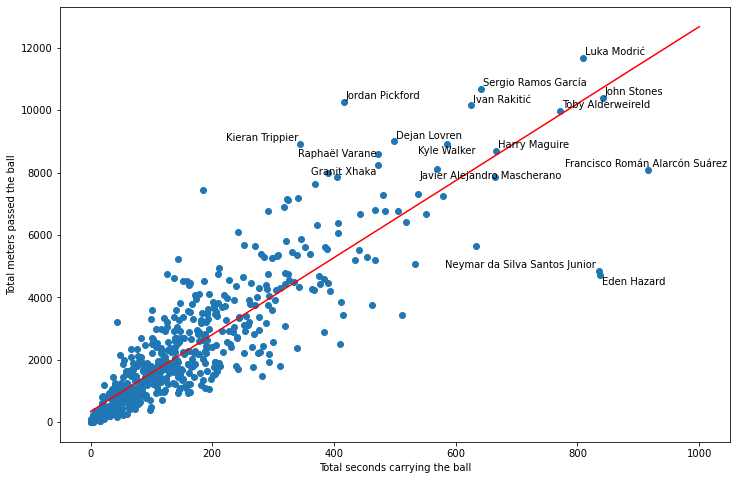

In [28]:
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(CL_carry, CL_pass)
plt.plot(xfit1, yfit1, "r")
plt.xlabel("Total seconds carrying the ball")
plt.ylabel("Total meters passed the ball")

labels = [ax.annotate(txt, (CL_carry[i], CL_pass[i])) 
          for i, txt in enumerate(CL_carry.index) 
          if CL_carry.iloc[i] > 800 or CL_pass.iloc[i] > 8000]
adjust_text(labels)

plt.show()